In [37]:
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuration
SCENES_DIR = "scenes"
CHARACTERS_DIR = "character_frames_no_bg"
OUTPUT_DIR = "augmented_data"
ANNOTATIONS_DIR = os.path.join(OUTPUT_DIR, "annotations")
YOLO_LABELS_DIR = os.path.join(OUTPUT_DIR, "labels")  # YOLO format labels
NUM_ITERATIONS = 20000  # Change this to control how many images to generate
ENABLE_LIGHTING_ADJUSTMENT = True  # Set to False to disable lighting adjustment
LIGHTING_STRENGTH = 0.1  # How strong the lighting adjustment should be (0.0 = none, 1.0 = full)
MAX_CHARACTER_SCALE = 0.7  # Maximum allowed character scale to prevent unrealistically large characters

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

print(f"Configuration loaded:")
print(f"- Scenes directory: {SCENES_DIR}")
print(f"- Characters directory: {CHARACTERS_DIR}")
print(f"- Output directory: {OUTPUT_DIR}")
print(f"- YOLO labels directory: {YOLO_LABELS_DIR}")
print(f"- Number of iterations: {NUM_ITERATIONS}")
print(f"- Lighting adjustment: {'Enabled' if ENABLE_LIGHTING_ADJUSTMENT else 'Disabled'}")
if ENABLE_LIGHTING_ADJUSTMENT:
    print(f"- Lighting strength: {LIGHTING_STRENGTH}")
print(f"- Maximum character scale: {MAX_CHARACTER_SCALE}")

Configuration loaded:
- Scenes directory: scenes
- Characters directory: character_frames_no_bg
- Output directory: augmented_data
- YOLO labels directory: augmented_data/labels
- Number of iterations: 20000
- Lighting adjustment: Enabled
- Lighting strength: 0.1
- Maximum character scale: 0.7


In [38]:
# Load scene images and character poses
import glob

# Load scene images
print("Loading scene images...")
scene_paths = []
scene_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
for ext in scene_extensions:
    scene_paths.extend(glob.glob(os.path.join(SCENES_DIR, ext)))
    scene_paths.extend(glob.glob(os.path.join(SCENES_DIR, ext.upper())))

if not scene_paths:
    print(f"❌ No scene images found in {SCENES_DIR}")
    print(f"   Please ensure the scenes directory exists and contains images")
else:
    print(f"✅ Found {len(scene_paths)} scene images")

# Load character poses with filtering
print("Loading character poses...")
character_poses = {}

if os.path.exists(CHARACTERS_DIR):
    # Get all character directories
    character_dirs = [d for d in os.listdir(CHARACTERS_DIR) 
                     if os.path.isdir(os.path.join(CHARACTERS_DIR, d))]
    
    for char_dir in character_dirs:
        char_path = os.path.join(CHARACTERS_DIR, char_dir)
        
        # Find all images in this character directory
        char_images = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            char_images.extend(glob.glob(os.path.join(char_path, ext)))
            char_images.extend(glob.glob(os.path.join(char_path, ext.upper())))
        
        # Filter to only include specific pose numbers (2, 3, 5, 6)
        filtered_poses = []
        for img_path in char_images:
            img_name = os.path.basename(img_path)
            # Check if filename contains pose numbers 2, 3, 5, or 6
            # Format examples: character_2.png, 1_3.jpg, etc.
            if any(f"_{pose_num}" in img_name or img_name.startswith(f"{pose_num}_") 
                   for pose_num in ['2', '3', '5', '6']):
                filtered_poses.append(img_path)
        
        if filtered_poses:
            character_poses[char_dir] = filtered_poses

if not character_poses:
    print(f"❌ No character poses found in {CHARACTERS_DIR}")
    print(f"   Please ensure the characters directory exists and contains character subdirectories with images")
    print(f"   Looking for pose numbers: 2, 3, 5, 6 (e.g., character_2.png, 1_3.jpg)")
else:
    total_poses = sum(len(poses) for poses in character_poses.values())
    print(f"✅ Found {len(character_poses)} characters with {total_poses} total filtered poses")
    print(f"   Using only pose numbers: 2, 3, 5, 6")

# Load player regions from file
PLAYER_REGIONS_FILE = "scenes/player_regions.json"

def load_player_regions():
    """Load saved player regions from file"""
    if os.path.exists(PLAYER_REGIONS_FILE):
        try:
            with open(PLAYER_REGIONS_FILE, 'r') as f:
                regions = json.load(f)
            print(f"✅ Loaded player regions from {PLAYER_REGIONS_FILE}")
            return regions
        except Exception as e:
            print(f"❌ Error loading player regions: {e}")
            return {}
    else:
        print(f"⚠️  Player regions file not found: {PLAYER_REGIONS_FILE}")
        print("   No player regions will be used (characters can be placed anywhere)")
        return {}

# Load player regions
player_regions = load_player_regions()

if player_regions:
    scenes_with_regions = sum(1 for region in player_regions.values() if region is not None)
    total_scenes = len(player_regions)
    print(f"   Found regions for {scenes_with_regions}/{total_scenes} scenes")
    
    # Show sample regions
    print("   Sample player regions:")
    for i, (scene, region) in enumerate(player_regions.items()):
        if i >= 3:  # Show only first 3
            break
        if region:
            print(f"     - {scene}: {region['width']}x{region['height']} at ({region['x']}, {region['y']})")
        else:
            print(f"     - {scene}: No player region")
    
    if len(player_regions) > 3:
        print(f"     ... and {len(player_regions) - 3} more scenes")
else:
    print("   No player regions loaded - characters can be placed anywhere")

Loading scene images...
✅ Found 17 scene images
Loading character poses...
✅ Found 987 characters with 3952 total filtered poses
   Using only pose numbers: 2, 3, 5, 6
✅ Loaded player regions from scenes/player_regions.json
   Found regions for 15/18 scenes
   Sample player regions:
     - 14.jpg: 420x490 at (472, 429)
     - 11.jpg: 464x523 at (482, 398)
     - 7.jpg: 348x554 at (561, 365)
     ... and 15 more scenes


In [39]:
def adjust_lighting(character_img, background_crop):
    """
    Adjust character lighting to match background using computer vision techniques
    Preserves alpha channel for transparent PNGs
    """
    # Check if lighting adjustment is disabled
    if not ENABLE_LIGHTING_ADJUSTMENT:
        return character_img
        
    try:
        # Preserve alpha channel if present
        has_alpha = character_img.shape[2] == 4
        if has_alpha:
            alpha_channel = character_img[:, :, 3]
            char_rgb = character_img[:, :, :3]
        else:
            char_rgb = character_img
        
        # Convert to LAB color space for better lighting adjustment
        char_lab = cv2.cvtColor(char_rgb, cv2.COLOR_RGB2LAB)
        bg_lab = cv2.cvtColor(background_crop, cv2.COLOR_RGB2LAB)
        
        # Split channels (L=lightness, A and B are color channels)
        char_l, char_a, char_b = cv2.split(char_lab)
        bg_l, bg_a, bg_b = cv2.split(bg_lab)
        
        # Calculate statistics for background lighting
        bg_mean = np.mean(bg_l)
        bg_std = np.std(bg_l)
        char_mean = np.mean(char_l)
        char_std = np.std(char_l)
        
        # Adjust character lightness to match background (more subtle)
        if char_std > 0:
            # Use configurable lighting strength to prevent overexposure
            char_l_normalized = (char_l - char_mean) / char_std
            char_l_adjusted = char_l + (char_l_normalized * bg_std + bg_mean - char_l) * LIGHTING_STRENGTH
            char_l_adjusted = np.clip(char_l_adjusted, 0, 255).astype(np.uint8)
        else:
            char_l_adjusted = char_l
        
        # Very subtle color temperature adjustment
        bg_color_temp = np.mean(bg_a), np.mean(bg_b)
        char_color_temp = np.mean(char_a), np.mean(char_b)
        
        # Even more subtle color temperature shift
        temp_diff_a = (bg_color_temp[0] - char_color_temp[0]) * (LIGHTING_STRENGTH * 0.3)
        temp_diff_b = (bg_color_temp[1] - char_color_temp[1]) * (LIGHTING_STRENGTH * 0.3)
        
        char_a_adjusted = np.clip(char_a + temp_diff_a, 0, 255).astype(np.uint8)
        char_b_adjusted = np.clip(char_b + temp_diff_b, 0, 255).astype(np.uint8)
        
        # Merge channels back
        char_lab_adjusted = cv2.merge([char_l_adjusted, char_a_adjusted, char_b_adjusted])
        char_rgb_adjusted = cv2.cvtColor(char_lab_adjusted, cv2.COLOR_LAB2RGB)
        
        # Restore alpha channel if it was present
        if has_alpha:
            char_adjusted = np.dstack([char_rgb_adjusted, alpha_channel])
        else:
            char_adjusted = char_rgb_adjusted
        
        return char_adjusted
        
    except Exception as e:
        print(f"Lighting adjustment failed: {e}")
        return character_img

def bbox_to_yolo_format(bbox, img_width, img_height):
    """
    Convert bounding box to YOLO format
    
    Args:
        bbox: dict with 'x', 'y', 'width', 'height' (absolute coordinates)
        img_width: image width
        img_height: image height
    
    Returns:
        tuple: (center_x, center_y, width, height) normalized to [0, 1]
    """
    # Calculate center coordinates
    center_x = bbox['x'] + bbox['width'] / 2
    center_y = bbox['y'] + bbox['height'] / 2
    
    # Normalize to [0, 1]
    center_x_norm = center_x / img_width
    center_y_norm = center_y / img_height
    width_norm = bbox['width'] / img_width
    height_norm = bbox['height'] / img_height
    
    return center_x_norm, center_y_norm, width_norm, height_norm

def save_yolo_annotation(annotation_data, character_classes):
    """
    Save annotation in YOLO format
    
    Args:
        annotation_data: annotation dictionary
        character_classes: mapping of character names to class IDs
    """
    # Create YOLO format filename (same as image but with .txt extension)
    image_name = annotation_data['image_name']
    yolo_filename = os.path.splitext(image_name)[0] + '.txt'
    yolo_path = os.path.join(YOLO_LABELS_DIR, yolo_filename)
    
    img_width = annotation_data['image_width']
    img_height = annotation_data['image_height']
    
    with open(yolo_path, 'w') as f:
        for char_info in annotation_data['characters']:
            char_name = char_info['character_name']
            class_id = character_classes[char_name]
            bbox = char_info['bbox']
            
            # Convert to YOLO format
            center_x, center_y, width, height = bbox_to_yolo_format(bbox, img_width, img_height)
            
            # Write YOLO format: class_id center_x center_y width height
            f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")
    
    return yolo_path

In [40]:
def place_character_on_scene(scene_img, char_img, existing_bboxes=None, player_region=None):
    """
    Place character on scene with realistic sizing based on Y position (depth simulation)
    
    Args:
        scene_img: Background scene image (RGB)
        char_img: Character image (RGB or RGBA)
        existing_bboxes: List of existing character bounding boxes to avoid overlap
        player_region: Player character region to avoid (dict with x, y, width, height)
    
    Returns:
        Modified scene image, character bounding box info
    """
    if existing_bboxes is None:
        existing_bboxes = []
    
    scene_h, scene_w = scene_img.shape[:2]
    char_h, char_w = char_img.shape[:2]
    
    # Function to check if two bounding boxes overlap
    def boxes_overlap(box1, box2, margin=10):
        """Check if two bounding boxes overlap with optional margin"""
        x1, y1, w1, h1 = box1['x'] - margin, box1['y'] - margin, box1['width'] + 2*margin, box1['height'] + 2*margin
        x2, y2, w2, h2 = box2['x'] - margin, box2['y'] - margin, box2['width'] + 2*margin, box2['height'] + 2*margin
        
        # Check if boxes don't overlap (then return False)
        if (x1 >= x2 + w2 or x2 >= x1 + w1 or y1 >= y2 + h2 or y2 >= y1 + h1):
            return False
        return True
    
    # Try to find a valid position first, then calculate size based on Y position
    max_attempts = 50  # Maximum attempts to find a valid position
    attempts = 0
    
    while attempts < max_attempts:
        # Start with a base scale to determine initial character size for placement
        base_scale = random.uniform(0.2, 0.6)  # Initial scale for position testing
        
        # Resize character for initial placement testing
        test_char_w = int(char_w * base_scale)
        test_char_h = int(char_h * base_scale)
        
        # Random position ensuring character is fully within scene
        max_x = scene_w - test_char_w
        max_y = scene_h - test_char_h
        
        if max_x <= 0 or max_y <= 0:
            # Try smaller scale
            base_scale *= 0.8
            test_char_w = int(char_w * base_scale)
            test_char_h = int(char_h * base_scale)
            max_x = scene_w - test_char_w
            max_y = scene_h - test_char_h
            
            if max_x <= 0 or max_y <= 0:
                return scene_img, None  # Character too large even with smaller scale
        
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)
        
        # Now calculate realistic size based on Y position (depth)
        # Y position normalized to [0, 1] where 0=top (far), 1=bottom (close)
        depth_factor = y / scene_h
        
        # Calculate final scale based on depth
        # Characters at top (depth_factor=0) are smaller, at bottom (depth_factor=1) are larger
        min_scale = 0.15  # Minimum scale for far characters
        max_scale = 0.8   # Maximum scale for close characters
        depth_scale = min_scale + (depth_factor * (max_scale - min_scale))
        
        # Add some random variation (±15%)
        scale_variation = random.uniform(0.85, 1.15)
        final_scale = depth_scale * scale_variation
        
        # Apply maximum character scale limit to prevent unrealistically large characters
        final_scale = min(final_scale, MAX_CHARACTER_SCALE)
        
        # Calculate final character dimensions
        new_char_w = int(char_w * final_scale)
        new_char_h = int(char_h * final_scale)
        
        # Ensure character still fits at this position with new size
        if x + new_char_w > scene_w or y + new_char_h > scene_h:
            # Adjust position if character doesn't fit
            max_x = scene_w - new_char_w
            max_y = scene_h - new_char_h
            
            if max_x < 0 or max_y < 0:
                attempts += 1
                continue  # Try again with different position
            
            x = min(x, max_x)
            y = min(y, max_y)
        
        # Create current bounding box with final dimensions
        current_bbox = {
            'x': x,
            'y': y,
            'width': new_char_w,
            'height': new_char_h
        }
        
        # Check if this position overlaps with any existing characters
        overlaps = False
        for existing_bbox in existing_bboxes:
            if boxes_overlap(current_bbox, existing_bbox):
                overlaps = True
                break
        
        # Check if this position overlaps with player region
        if not overlaps and player_region is not None:
            if boxes_overlap(current_bbox, player_region, margin=20):  # Extra margin around player
                overlaps = True
        
        if not overlaps:
            # Found a valid position, break out of the loop
            break
        
        attempts += 1
    
    # If we couldn't find a non-overlapping position after max attempts
    if attempts >= max_attempts:
        print(f"    Could not find non-overlapping position after {max_attempts} attempts")
        return scene_img, None
    
    # Resize character to final size
    char_resized = cv2.resize(char_img, (new_char_w, new_char_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Extract background crop around character position for lighting adjustment
    crop_margin = 30
    crop_x1 = max(0, x - crop_margin)
    crop_y1 = max(0, y - crop_margin)
    crop_x2 = min(scene_w, x + new_char_w + crop_margin)
    crop_y2 = min(scene_h, y + new_char_h + crop_margin)
    
    background_crop = scene_img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # Adjust character lighting to match background (preserve alpha channel)
    char_adjusted = adjust_lighting(char_resized, background_crop)
    
    # Use existing alpha channel from PNG
    if char_adjusted.shape[2] == 4:
        # PNG with alpha channel - use it directly
        alpha_mask = char_adjusted[:, :, 3].astype(np.float32) / 255.0
        char_rgb = char_adjusted[:, :, :3]
        print(f"    Using PNG alpha channel, alpha range: {alpha_mask.min():.3f} to {alpha_mask.max():.3f}")
    else:
        # Fallback: assume all pixels are opaque
        alpha_mask = np.ones((new_char_h, new_char_w), dtype=np.float32)
        char_rgb = char_adjusted
        print(f"    No alpha channel found, using opaque mask")
    
    # Expand alpha mask to 3 channels for blending
    alpha_3d = np.stack([alpha_mask] * 3, axis=2)
    
    # Blend character onto scene using vectorized operations
    scene_region = scene_img[y:y+new_char_h, x:x+new_char_w]
    blended_region = (1 - alpha_3d) * scene_region + alpha_3d * char_rgb
    scene_img[y:y+new_char_h, x:x+new_char_w] = blended_region.astype(np.uint8)
    
    # Return bounding box info for annotations
    bbox_info = {
        'x': x,
        'y': y,
        'width': new_char_w,
        'height': new_char_h,
        'depth_factor': depth_factor,  # Y position normalized (0=top/far, 1=bottom/close)
        'scale': final_scale,
        'y_position': y  # Actual Y position in image
    }
    
    return scene_img, bbox_info

In [41]:
def generate_augmented_image(iteration_num):
    """
    Generate one augmented image with randomly placed characters
    
    Args:
        iteration_num: Current iteration number for naming
    
    Returns:
        Success status and annotation data
    """
    if not scene_paths:
        print("No scene images found!")
        return False, None
    
    if not character_poses:
        print("No character poses found!")
        return False, None
    
    # Step 1: Randomly select scene image
    scene_path = random.choice(scene_paths)
    
    # Get player region for this scene
    scene_key = os.path.basename(scene_path)
    player_region = player_regions.get(scene_key) if 'player_regions' in globals() else None
    
    try:
        scene_img = cv2.imread(scene_path)
        if scene_img is None:
            print(f"Failed to load scene: {scene_path}")
            return False, None
        scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading scene {scene_path}: {e}")
        return False, None
    
    # Step 2: Randomly select number of characters (1-4)
    num_characters = random.randint(1, 4)
    
    # Step 3: Randomly select characters
    available_characters = list(character_poses.keys())
    if len(available_characters) < num_characters:
        selected_characters = available_characters
    else:
        selected_characters = random.sample(available_characters, num_characters)
    
    # Store annotation data
    annotation_data = {
        'image_name': f"{iteration_num}.jpg",  # Simple numbering: 1.jpg, 2.jpg, etc.
        'scene_source': scene_path,
        'characters': [],
        'image_width': scene_img.shape[1],
        'image_height': scene_img.shape[0]
    }
    
    print(f"Iteration {iteration_num}: Placing {num_characters} characters on scene")
    if player_region:
        print(f"  - Player region: {player_region['width']}x{player_region['height']} at ({player_region['x']}, {player_region['y']})")
    else:
        print(f"  - No player region defined for this scene")
    
    # Track placed character bounding boxes to prevent overlaps
    placed_bboxes = []
    
    # Step 4: Place each character
    for i, char_name in enumerate(selected_characters):
        # Step 5: Randomly select pose for this character
        char_poses = character_poses[char_name]
        selected_pose = random.choice(char_poses)
        
        try:
            # Load with alpha channel preserved for transparent PNGs
            char_img = cv2.imread(selected_pose, cv2.IMREAD_UNCHANGED)
            if char_img is None:
                print(f"Failed to load character pose: {selected_pose}")
                continue
            
            # Convert to RGB while preserving alpha if present
            if char_img.shape[2] == 4:  # RGBA
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGRA2RGBA)
            else:  # RGB
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading character {selected_pose}: {e}")
            continue
        
        # Step 6: Character size will be determined by Y position (depth) during placement
        # No need for random distance factor - position-based sizing provides realism
        
        # Step 7: Place character on scene (with overlap prevention and player region avoidance)
        scene_img, bbox_info = place_character_on_scene(scene_img, char_img, placed_bboxes, player_region)
        
        if bbox_info is not None:
            # Add this bounding box to the list of placed characters
            placed_bboxes.append(bbox_info)
            
            # Store character info for annotations
            char_info = {
                'character_name': char_name,
                'pose_source': selected_pose,
                'bbox': bbox_info,
                'character_index': i
            }
            annotation_data['characters'].append(char_info)
            print(f"  - Placed {char_name} at ({bbox_info['x']}, {bbox_info['y']}) "
                  f"size: {bbox_info['width']}x{bbox_info['height']} "
                  f"depth: {bbox_info['depth_factor']:.2f} (Y-pos: {bbox_info['y_position']})")
        else:
            print(f"  - Failed to place {char_name} (character too large, overlapping, or in player region)")
    
    # Step 8: Save augmented image
    output_path = os.path.join(OUTPUT_DIR, annotation_data['image_name'])
    scene_img_bgr = cv2.cvtColor(scene_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, scene_img_bgr)
    
    # Step 9: Save annotation data (JSON format)
    annotation_path = os.path.join(ANNOTATIONS_DIR, f"{iteration_num}.json")
    with open(annotation_path, 'w') as f:
        json.dump(annotation_data, f, indent=2)
    
    # Step 10: Save YOLO format annotation
    yolo_path = save_yolo_annotation(annotation_data, character_classes)
    
    print(f"  - Saved image: {output_path}")
    print(f"  - Saved JSON: {annotation_path}")
    print(f"  - Saved YOLO: {yolo_path}")
    
    return True, annotation_data

Testing mask creation with: 10634
Image shape: (1290, 830, 4) (RGBA)


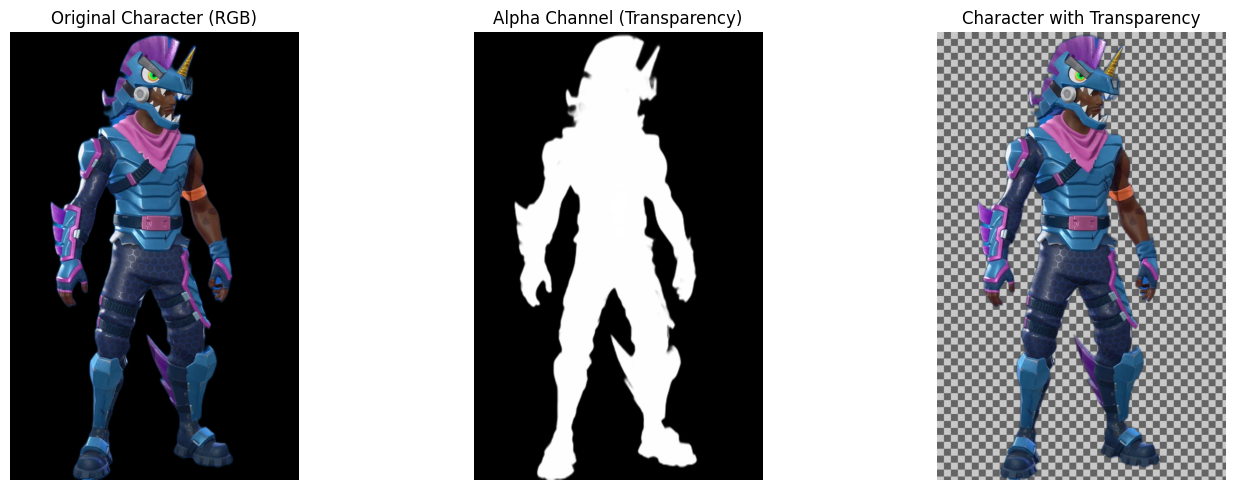

In [42]:
def debug_mask_creation(char_img, save_debug=False):
    """Debug function to visualize transparency for PNG files"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(char_img[:, :, :3])  # Show RGB channels only
    axes[0].set_title('Original Character (RGB)')
    axes[0].axis('off')
    
    # Show alpha channel if available
    if char_img.shape[2] == 4:
        alpha_channel = char_img[:, :, 3]
        axes[1].imshow(alpha_channel, cmap='gray')
        axes[1].set_title('Alpha Channel (Transparency)')
        axes[1].axis('off')
        
        # Show character with transparency on checkerboard
        h, w = char_img.shape[:2]
        checkerboard = np.zeros((h, w, 3), dtype=np.uint8)
        square_size = 20
        for i in range(0, h, square_size):
            for j in range(0, w, square_size):
                if (i // square_size + j // square_size) % 2 == 0:
                    checkerboard[i:i+square_size, j:j+square_size] = [200, 200, 200]
                else:
                    checkerboard[i:i+square_size, j:j+square_size] = [100, 100, 100]
        
        # Apply transparency
        alpha_mask = alpha_channel.astype(np.float32) / 255.0
        alpha_3d = np.stack([alpha_mask] * 3, axis=2)
        char_rgb = char_img[:, :, :3]
        result = (1 - alpha_3d) * checkerboard + alpha_3d * char_rgb
        
        axes[2].imshow(result.astype(np.uint8))
        axes[2].set_title('Character with Transparency')
        axes[2].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No Alpha Channel\n(RGB image)', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
        axes[1].axis('off')
        
        axes[2].imshow(char_img)
        axes[2].set_title('Character (No Transparency)')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if char_img.shape[2] == 4:
        return char_img[:, :, 3]  # Return alpha channel
    else:
        return None

# Test mask creation with a sample character (if available)
if character_poses:
    sample_char = list(character_poses.keys())[0]
    sample_pose = character_poses[sample_char][0]
    
    try:
        # Load with alpha channel preserved for transparent PNGs
        test_img = cv2.imread(sample_pose, cv2.IMREAD_UNCHANGED)
        if test_img.shape[2] == 4:  # RGBA
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2RGBA)
        else:  # RGB
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        print(f"Testing mask creation with: {sample_char}")
        print(f"Image shape: {test_img.shape} ({'RGBA' if test_img.shape[2] == 4 else 'RGB'})")
        debug_mask_creation(test_img)
    except Exception as e:
        print(f"Could not load test image: {e}")

In [27]:
# # Interactive Region Selection for Player Character Areas
# import tkinter as tk
# from tkinter import messagebox
# from PIL import Image, ImageTk

# # File to save player regions
# PLAYER_REGIONS_FILE = "scenes/player_regions.json"

# def load_player_regions():
#     """Load saved player regions from file"""
#     if os.path.exists(PLAYER_REGIONS_FILE):
#         try:
#             with open(PLAYER_REGIONS_FILE, 'r') as f:
#                 return json.load(f)
#         except Exception as e:
#             print(f"Error loading player regions: {e}")
#     return {}

# def save_player_regions(regions):
#     """Save player regions to file"""
#     try:
#         with open(PLAYER_REGIONS_FILE, 'w') as f:
#             json.dump(regions, f, indent=2)
#         print(f"Player regions saved to {PLAYER_REGIONS_FILE}")
#     except Exception as e:
#         print(f"Error saving player regions: {e}")

# class RegionSelector:
#     def __init__(self, image_path, existing_region=None):
#         self.image_path = image_path
#         self.existing_region = existing_region
#         self.start_x = None
#         self.start_y = None
#         self.rect_id = None
#         self.selected_region = None
        
#         # Create main window
#         self.root = tk.Tk()
#         self.root.title(f"Select Player Region - {os.path.basename(image_path)}")
        
#         # Load and display image
#         self.setup_image()
#         self.setup_ui()
        
#     def setup_image(self):
#         """Load and setup the image for display"""
#         # Load image
#         pil_image = Image.open(self.image_path)
        
#         # Calculate display size (max 800x600 while maintaining aspect ratio)
#         max_width, max_height = 800, 600
#         img_width, img_height = pil_image.size
        
#         scale = min(max_width / img_width, max_height / img_height, 1.0)
#         self.scale = scale
        
#         display_width = int(img_width * scale)
#         display_height = int(img_height * scale)
        
#         self.display_image = pil_image.resize((display_width, display_height), Image.Resampling.LANCZOS)
#         self.photo = ImageTk.PhotoImage(self.display_image)
        
#         # Store original dimensions for coordinate conversion
#         self.original_width = img_width
#         self.original_height = img_height
#         self.display_width = display_width
#         self.display_height = display_height
        
#     def setup_ui(self):
#         """Setup the user interface"""
#         # Instructions
#         instructions = tk.Label(
#             self.root, 
#             text="Click and drag to select the player character region.\nThis area will be excluded from enemy placement.",
#             justify=tk.CENTER,
#             pady=10
#         )
#         instructions.pack()
        
#         # Canvas for image and selection
#         self.canvas = tk.Canvas(
#             self.root, 
#             width=self.display_width, 
#             height=self.display_height,
#             bg='white'
#         )
#         self.canvas.pack(padx=10, pady=5)
        
#         # Display image
#         self.canvas.create_image(0, 0, anchor=tk.NW, image=self.photo)
        
#         # Show existing region if available
#         if self.existing_region:
#             self.draw_existing_region()
        
#         # Bind mouse events
#         self.canvas.bind("<Button-1>", self.on_click)
#         self.canvas.bind("<B1-Motion>", self.on_drag)
#         self.canvas.bind("<ButtonRelease-1>", self.on_release)
        
#         # Buttons
#         button_frame = tk.Frame(self.root)
#         button_frame.pack(pady=10)
        
#         tk.Button(
#             button_frame, 
#             text="Save Region", 
#             command=self.save_region,
#             bg='green',
#             fg='white',
#             font=('Arial', 10, 'bold')
#         ).pack(side=tk.LEFT, padx=5)
        
#         tk.Button(
#             button_frame, 
#             text="Clear Region", 
#             command=self.clear_region,
#             bg='orange',
#             fg='white',
#             font=('Arial', 10, 'bold')
#         ).pack(side=tk.LEFT, padx=5)
        
#         tk.Button(
#             button_frame, 
#             text="Skip (No Player Region)", 
#             command=self.skip_region,
#             bg='blue',
#             fg='white',
#             font=('Arial', 10, 'bold')
#         ).pack(side=tk.LEFT, padx=5)
        
#         tk.Button(
#             button_frame, 
#             text="Cancel", 
#             command=self.cancel,
#             bg='red',
#             fg='white',
#             font=('Arial', 10, 'bold')
#         ).pack(side=tk.LEFT, padx=5)
        
#         # Status label
#         self.status_label = tk.Label(self.root, text="Click and drag to select region", fg='blue')
#         self.status_label.pack(pady=5)
        
#     def draw_existing_region(self):
#         """Draw existing region if available"""
#         region = self.existing_region
#         # Convert from original coordinates to display coordinates
#         x1 = int(region['x'] * self.scale)
#         y1 = int(region['y'] * self.scale)
#         x2 = int((region['x'] + region['width']) * self.scale)
#         y2 = int((region['y'] + region['height']) * self.scale)
        
#         self.rect_id = self.canvas.create_rectangle(
#             x1, y1, x2, y2,
#             outline='red',
#             width=3,
#             stipple='gray50'
#         )
#         self.status_label.config(text="Existing region shown. Modify by dragging or clear to start over.")
        
#     def on_click(self, event):
#         """Handle mouse click"""
#         # Clear previous rectangle
#         if self.rect_id:
#             self.canvas.delete(self.rect_id)
            
#         self.start_x = event.x
#         self.start_y = event.y
        
#     def on_drag(self, event):
#         """Handle mouse drag"""
#         if self.start_x is not None and self.start_y is not None:
#             # Clear previous rectangle
#             if self.rect_id:
#                 self.canvas.delete(self.rect_id)
                
#             # Draw new rectangle
#             self.rect_id = self.canvas.create_rectangle(
#                 self.start_x, self.start_y, event.x, event.y,
#                 outline='red',
#                 width=3,
#                 stipple='gray50'
#             )
            
#     def on_release(self, event):
#         """Handle mouse release"""
#         if self.start_x is not None and self.start_y is not None:
#             # Calculate region in original image coordinates
#             x1 = min(self.start_x, event.x) / self.scale
#             y1 = min(self.start_y, event.y) / self.scale
#             x2 = max(self.start_x, event.x) / self.scale
#             y2 = max(self.start_y, event.y) / self.scale
            
#             # Ensure coordinates are within image bounds
#             x1 = max(0, min(x1, self.original_width))
#             y1 = max(0, min(y1, self.original_height))
#             x2 = max(0, min(x2, self.original_width))
#             y2 = max(0, min(y2, self.original_height))
            
#             if abs(x2 - x1) > 10 and abs(y2 - y1) > 10:  # Minimum size
#                 self.selected_region = {
#                     'x': int(x1),
#                     'y': int(y1),
#                     'width': int(x2 - x1),
#                     'height': int(y2 - y1)
#                 }
#                 self.status_label.config(
#                     text=f"Region selected: {int(x2-x1)}x{int(y2-y1)} at ({int(x1)}, {int(y1)})",
#                     fg='green'
#                 )
#             else:
#                 self.status_label.config(text="Region too small, try again", fg='red')
#                 if self.rect_id:
#                     self.canvas.delete(self.rect_id)
#                     self.rect_id = None
                    
#     def clear_region(self):
#         """Clear the selected region"""
#         if self.rect_id:
#             self.canvas.delete(self.rect_id)
#             self.rect_id = None
#         self.selected_region = None
#         self.status_label.config(text="Region cleared. Click and drag to select new region", fg='blue')
        
#     def save_region(self):
#         """Save the selected region and close"""
#         if self.selected_region:
#             self.root.quit()
#         else:
#             messagebox.showwarning("No Region", "Please select a region first, or click 'Skip' if there's no player character.")
            
#     def skip_region(self):
#         """Skip region selection (no player character in this scene)"""
#         self.selected_region = None
#         self.root.quit()
        
#     def cancel(self):
#         """Cancel region selection"""
#         self.selected_region = "CANCELLED"
#         self.root.quit()
        
#     def run(self):
#         """Run the region selector"""
#         self.root.mainloop()
#         self.root.destroy()
#         return self.selected_region

# def select_player_regions_interactive(force_reselect=False):
#     """
#     Interactive selection of player character regions for all scene images
    
#     Args:
#         force_reselect: If True, will ask to reselect regions even if they exist
    
#     Returns:
#         Dictionary mapping scene paths to player regions
#     """
#     if not scene_paths:
#         print("No scene images found!")
#         return {}
    
#     # Load existing regions
#     existing_regions = load_player_regions()
    
#     # Check if we need to do selection
#     if not force_reselect and existing_regions:
#         # Check if all current scenes have regions defined
#         scenes_with_regions = 0
#         for scene_path in scene_paths:
#             scene_key = os.path.basename(scene_path)
#             if scene_key in existing_regions:
#                 scenes_with_regions += 1
        
#         if scenes_with_regions == len(scene_paths):
#             print(f"All {len(scene_paths)} scenes already have player regions defined.")
#             response = input("Do you want to reselect regions? (y/N): ").strip().lower()
#             if response != 'y':
#                 print("Using existing player regions.")
#                 return existing_regions
    
#     print(f"Starting interactive player region selection for {len(scene_paths)} scenes...")
#     print("=" * 60)
#     print("INSTRUCTIONS:")
#     print("- Click and drag to select the area containing YOUR player character")
#     print("- This area will be excluded from enemy character placement")
#     print("- Click 'Save Region' when satisfied with selection")
#     print("- Click 'Skip' if there's no player character visible in the scene")
#     print("- Click 'Cancel' to stop the process")
#     print("=" * 60)
    
#     updated_regions = existing_regions.copy()
    
#     for i, scene_path in enumerate(scene_paths):
#         scene_key = os.path.basename(scene_path)
        
#         print(f"\nProcessing scene {i+1}/{len(scene_paths)}: {scene_key}")
        
#         # Check if region already exists
#         existing_region = existing_regions.get(scene_key)
#         if existing_region and not force_reselect:
#             print(f"  Region already exists: {existing_region}")
#             response = input("  Keep existing region? (Y/n): ").strip().lower()
#             if response != 'n':
#                 continue
        
#         # Run region selector
#         try:
#             selector = RegionSelector(scene_path, existing_region)
#             result = selector.run()
            
#             if result == "CANCELLED":
#                 print("Region selection cancelled by user.")
#                 break
#             elif result is None:
#                 print(f"  No player region selected for {scene_key}")
#                 updated_regions[scene_key] = None
#             else:
#                 print(f"  Player region selected: {result}")
#                 updated_regions[scene_key] = result
                
#         except Exception as e:
#             print(f"  Error selecting region for {scene_path}: {e}")
#             continue
    
#     # Save updated regions
#     save_player_regions(updated_regions)
    
#     return updated_regions

# # Load or select player regions
# print("Checking for player character regions...")
# player_regions = select_player_regions_interactive()

# print(f"\nPlayer regions loaded for {len([r for r in player_regions.values() if r is not None])} scenes")
# print("You can run this cell again with force_reselect=True to reselect regions if needed")

Visualizing player regions on sample scenes...


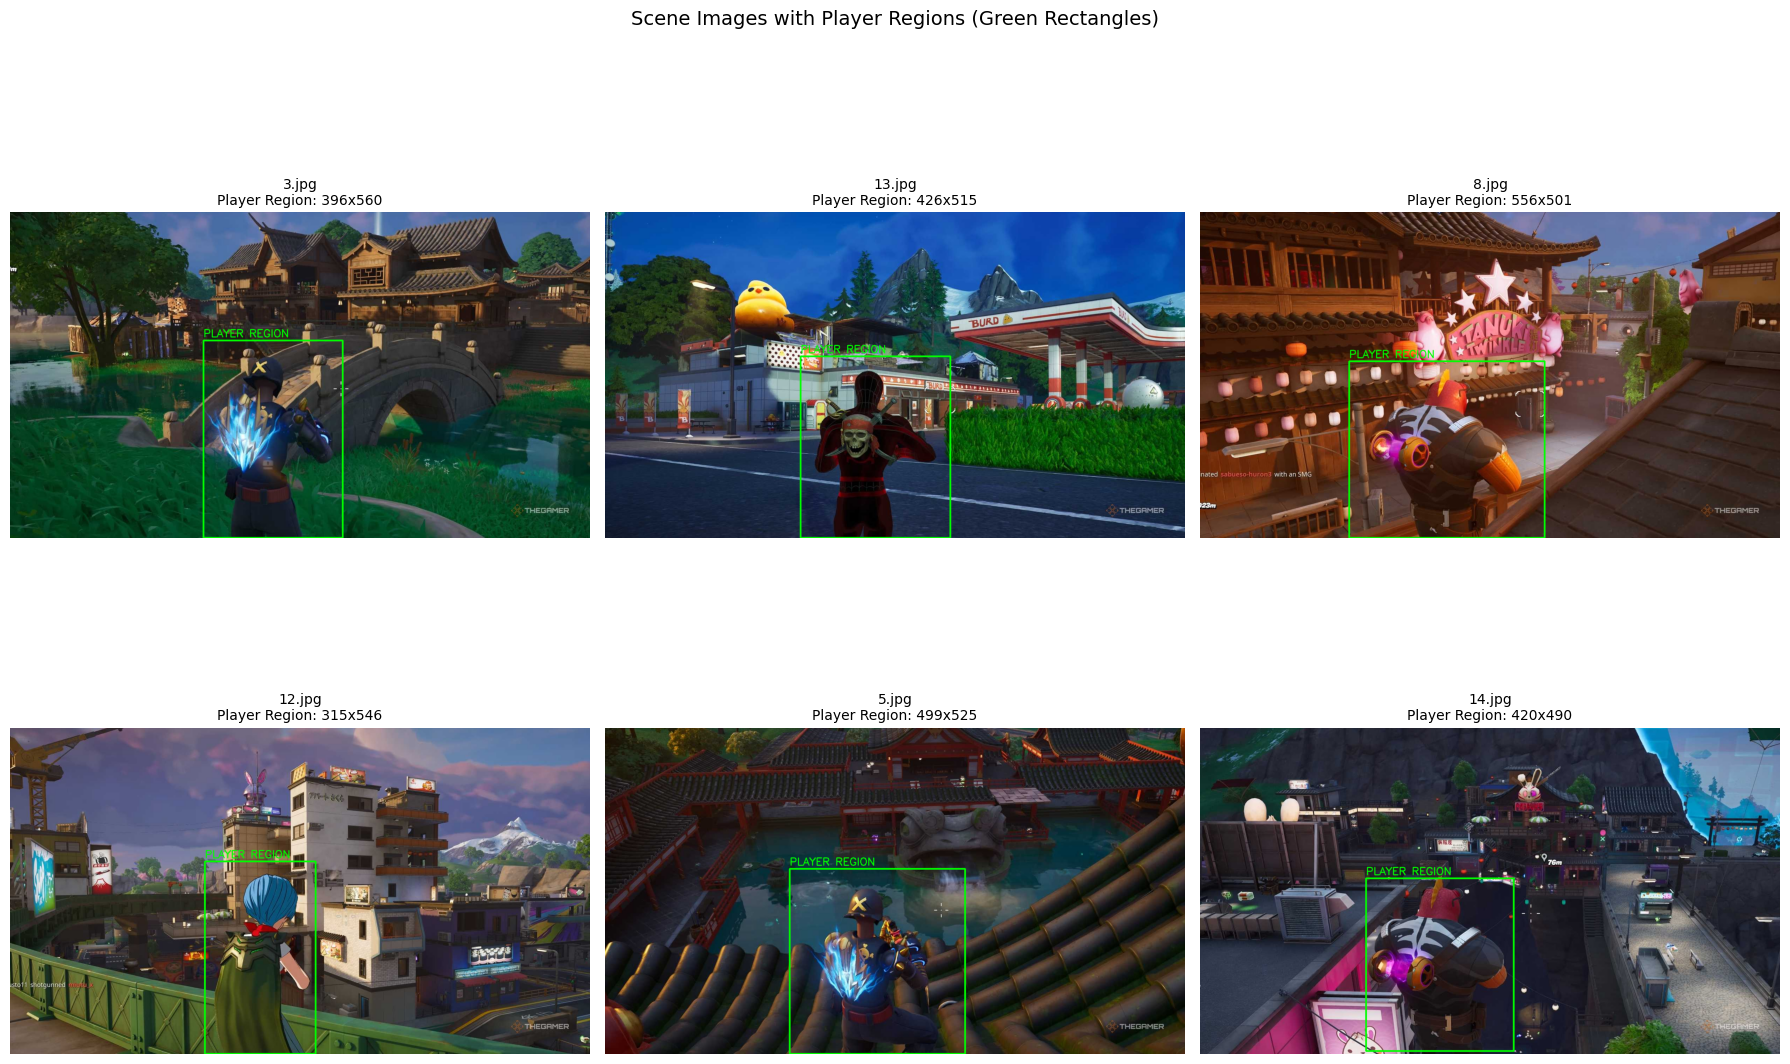

In [43]:
def visualize_player_regions(num_samples=6):
    """Visualize player regions on sample scene images"""
    if not scene_paths:
        print("No scene images to visualize!")
        return
    
    if 'player_regions' not in globals():
        print("No player regions loaded. Run the region selection cell first.")
        return
    
    # Select random scenes to show
    sample_scenes = random.sample(scene_paths, min(num_samples, len(scene_paths)))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, scene_path in enumerate(sample_scenes):
        if i >= len(axes):
            break
            
        try:
            # Load image
            img = cv2.imread(scene_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            scene_key = os.path.basename(scene_path)
            player_region = player_regions.get(scene_key)
            
            if player_region:
                # Draw player region rectangle
                x, y, w, h = player_region['x'], player_region['y'], player_region['width'], player_region['height']
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
                
                # Add label
                cv2.putText(img, "PLAYER REGION", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                           1, (0, 255, 0), 2)
                title = f"{scene_key}\nPlayer Region: {w}x{h}"
            else:
                title = f"{scene_key}\nNo Player Region"
            
            axes[i].imshow(img)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error visualizing {scene_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{os.path.basename(scene_path)}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_scenes), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Scene Images with Player Regions (Green Rectangles)", y=1.02, fontsize=14)
    plt.show()

# Visualize player regions if they exist
if 'player_regions' in globals() and player_regions:
    print("Visualizing player regions on sample scenes...")
    visualize_player_regions()
else:
    print("Player regions not yet defined. Run the interactive selection above first.")

In [44]:
# Create single class mapping for YOLO - all characters are "person"
character_classes = {}
class_names = ["person"]  # Use 'person' class to leverage pre-trained YOLO weights
for char_name in character_poses.keys():
    character_classes[char_name] = 0  # All characters get class ID 0 (person)

print(f"Found {len(scene_paths)} scene images")
print(f"Found {len(character_poses)} characters with filtered poses:")
print(f"Using only pose numbers: 2, 3, 5, 6 (e.g., 1_2, 1_3, 1_5, 1_6)")
for char, poses in list(character_poses.items())[:5]:  # Show first 5
    print(f"  - {char}: {len(poses)} poses (class_id: person)")
if len(character_poses) > 5:
    print(f"  ... and {len(character_poses) - 5} more characters")
print(f"All characters will be labeled as class 'person' (class_id: 0)")

# Save class names file for YOLO
class_names_path = os.path.join(OUTPUT_DIR, "classes.txt")
with open(class_names_path, 'w') as f:
    f.write("person\n")
print(f"Saved class names to: {class_names_path}")

Found 17 scene images
Found 987 characters with filtered poses:
Using only pose numbers: 2, 3, 5, 6 (e.g., 1_2, 1_3, 1_5, 1_6)
  - 10634: 4 poses (class_id: person)
  - 869: 4 poses (class_id: person)
  - 16197: 4 poses (class_id: person)
  - 338: 4 poses (class_id: person)
  - 738: 4 poses (class_id: person)
  ... and 982 more characters
All characters will be labeled as class 'person' (class_id: 0)
Saved class names to: augmented_data/classes.txt


In [45]:
# Main generation loop
print("=" * 60)
print("STARTING DATA GENERATION")
print("=" * 60)

# Initialize tracking variables
successful_generations = 0
failed_generations = 0
all_annotations = []

# Check if we have the required data
if not scene_paths:
    print("❌ ERROR: No scene images found!")
    print(f"   Please add images to the '{SCENES_DIR}' directory")
elif not character_poses:
    print("❌ ERROR: No character poses found!")
    print(f"   Please add character directories with images to the '{CHARACTERS_DIR}' directory")
else:
    print(f"🚀 Generating {NUM_ITERATIONS} augmented images...")
    print(f"   Using {len(scene_paths)} scene images")
    print(f"   Using {len(character_poses)} character types")
    print(f"   Output directory: {OUTPUT_DIR}")
    print()
    
    # Progress tracking
    progress_interval = max(1, NUM_ITERATIONS // 20)  # Show progress every 5%
    
    for i in range(1, NUM_ITERATIONS + 1):
        try:
            # Show progress
            if i % progress_interval == 0 or i == 1:
                percentage = (i / NUM_ITERATIONS) * 100
                print(f"Progress: {i}/{NUM_ITERATIONS} ({percentage:.1f}%)")
            
            # Generate one augmented image
            success, annotation_data = generate_augmented_image(i)
            
            if success and annotation_data:
                successful_generations += 1
                all_annotations.append(annotation_data)
            else:
                failed_generations += 1
                print(f"❌ Failed to generate image {i}")
                
        except KeyboardInterrupt:
            print(f"\n⏹️  Generation stopped by user at iteration {i}")
            break
        except Exception as e:
            failed_generations += 1
            print(f"❌ Error generating image {i}: {str(e)}")
            continue
    
    print(f"\n" + "=" * 60)
    print("GENERATION COMPLETE!")
    print("=" * 60)
    print(f"✅ Successfully generated: {successful_generations} images")
    print(f"❌ Failed generations: {failed_generations}")
    if successful_generations > 0:
        success_rate = (successful_generations / (successful_generations + failed_generations)) * 100
        print(f"📊 Success rate: {success_rate:.1f}%")
    print()

STARTING DATA GENERATION
🚀 Generating 20000 augmented images...
   Using 17 scene images
   Using 987 character types
   Output directory: augmented_data

Progress: 1/20000 (0.0%)
Iteration 1: Placing 1 characters on scene
  - Player region: 348x554 at (561, 365)
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 9035 at (202, 6) size: 122x189 depth: 0.01 (Y-pos: 6)
  - Saved image: augmented_data/1.jpg
  - Saved JSON: augmented_data/annotations/1.json
  - Saved YOLO: augmented_data/labels/1.txt
Iteration 2: Placing 2 characters on scene
  - Player region: 961x478 at (297, 449)
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 9543 at (1080, 35) size: 123x192 depth: 0.04 (Y-pos: 35)
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 613 at (259, 27) size: 156x238 depth: 0.03 (Y-pos: 27)
  - Saved image: augmented_data/2.jpg
  - Saved JSON: augmented_data/annotations/2.json
  - Saved YOLO: augmented_data/labels/2.txt
Iteration 3: Placi

In [46]:
# Save master annotation file
master_annotation_path = os.path.join(OUTPUT_DIR, "master_annotations.json")
with open(master_annotation_path, 'w') as f:
    json.dump({
        'total_images': successful_generations,
        'num_classes': 1,  # Single class: person
        'classes': ["person"],
        'config': {
            'scenes_dir': SCENES_DIR,
            'characters_dir': CHARACTERS_DIR,
            'num_iterations': NUM_ITERATIONS,
            'lighting_adjustment': ENABLE_LIGHTING_ADJUSTMENT,
            'lighting_strength': LIGHTING_STRENGTH if ENABLE_LIGHTING_ADJUSTMENT else 0,
            'single_class': True,
            'class_name': 'person'
        },
        'annotations': all_annotations
    }, f, indent=2)

print(f"Master annotations saved: {master_annotation_path}")
print(f"Individual JSON annotations saved in: {ANNOTATIONS_DIR}")
print(f"YOLO format labels saved in: {YOLO_LABELS_DIR}")
print(f"Class names saved in: {class_names_path}")
print(f"Augmented images saved in: {OUTPUT_DIR}")

# Create dataset.yaml file for YOLO training
dataset_yaml_path = os.path.join(OUTPUT_DIR, "dataset.yaml")
with open(dataset_yaml_path, 'w') as f:
    f.write(f"path: {os.path.abspath(OUTPUT_DIR)}\n")
    f.write(f"train: .\n")  # All images in the same directory for now
    f.write(f"val: .\n")   # You can split this later
    f.write(f"\n")
    f.write(f"nc: 1\n")  # Only 1 class: person
    f.write(f"names:\n")
    f.write(f"  0: person\n")

print(f"YOLO dataset config saved: {dataset_yaml_path}")

Master annotations saved: augmented_data/master_annotations.json
Individual JSON annotations saved in: augmented_data/annotations
YOLO format labels saved in: augmented_data/labels
Class names saved in: augmented_data/classes.txt
Augmented images saved in: augmented_data
YOLO dataset config saved: augmented_data/dataset.yaml


In [ ]:
def analyze_generation_statistics():
    """Analyze and display statistics about the generated data"""
    if not all_annotations:
        print("No data to analyze!")
        return
    
    print("=" * 50)
    print("DATA GENERATION STATISTICS")
    print("=" * 50)
    
    # Character count distribution
    char_counts = [len(ann['characters']) for ann in all_annotations]
    print(f"Character count distribution:")
    for i in range(1, 5):
        count = char_counts.count(i)
        percentage = (count / len(char_counts)) * 100
        print(f"  {i} character(s): {count} images ({percentage:.1f}%)")
    
    # Most used characters
    char_usage = {}
    total_chars_placed = 0
    depth_factors = []
    
    for ann in all_annotations:
        for char_info in ann['characters']:
            char_name = char_info['character_name']
            char_usage[char_name] = char_usage.get(char_name, 0) + 1
            total_chars_placed += 1
            depth_factors.append(char_info['bbox']['depth_factor'])
    
    print(f"\nTotal characters placed: {total_chars_placed}")
    print(f"Average characters per image: {total_chars_placed/len(all_annotations):.2f}")
    
    # Top 10 most used characters
    top_chars = sorted(char_usage.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 most used characters:")
    for char, count in top_chars:
        percentage = (count / total_chars_placed) * 100
        print(f"  {char}: {count} times ({percentage:.1f}%)")
    
    # Depth distribution
    avg_depth = np.mean(depth_factors)
    print(f"\nDepth simulation (Y-position based):")
    print(f"  Average depth factor: {avg_depth:.3f}")
    print(f"  Min depth factor: {min(depth_factors):.3f}")
    print(f"  Max depth factor: {max(depth_factors):.3f}")
    
    # Depth distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(depth_factors, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Character Depth Factors (Y-Position Based)')
    plt.xlabel('Depth Factor (0.0=top/far, 1.0=bottom/close)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Character count pie chart
    plt.figure(figsize=(8, 8))
    char_count_labels = [f'{i} character(s)' for i in range(1, 5)]
    char_count_values = [char_counts.count(i) for i in range(1, 5)]
    plt.pie(char_count_values, labels=char_count_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Number of Characters per Image')
    plt.show()

# Run analysis (only if data has been generated)
if 'successful_generations' in globals() and successful_generations > 0:
    analyze_generation_statistics()
else:
    print("💡 No data generated yet. Run the main generation loop first to see statistics.")